In [22]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import numpy as np
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from keras.models import model_from_json
import random
import sys

## Preprocessing

In [23]:
df_lyrics = pd.read_csv('lyrics_cleaned.csv')

In [24]:
df_rock = df_lyrics[df_lyrics['genre']=='rock']
df_rock

,track_name,artist_name,genre,lyrics,cleaned_lyrics
1135,American Girl,Tom Petty and the Heartbreakers,rock,"\n\n[verse 1]\nwell, she was an american girl\...",well she was an american girl raised on promi...
1136,Even Flow,Pearl Jam,rock,[verse 1]freezin'rests his head on a pillow ma...,freezin rests his head on a pillow made of co...
1137,Do I Wanna Know?,Arctic Monkeys,rock,\n\n[verse 1]\nhave you got colour in your che...,have you got colour in your cheeks do you eve...
1138,Get Your Dirty Hands of My Baby,Top Cats,rock,[chorus]get your dirty handsoff my baby[verse ...,get your dirty handsoff my baby go somewhere ...
1139,Stuck On You,Elvis Presley,rock,[verse 1]you can shake an apple off an apple t...,you can shake an apple off an apple treeshake...
...,...,...,...,...,...
1674,Hemorrhage (In My Hands),Fuel,rock,\n\n[verse 1]\nmemories are just where you lea...,memories are just where you leave them drag t...
1675,Mr. Crowley,Ozzy Osbourne,rock,"[verse 1]mr. crowley, what went on in your hea...",mr crowley what went on in your head oh mr cr...
1676,Wish You Were Here,Incubus,rock,[verse 1]i dig my toes into the sandthe ocean ...,i dig my toes into the sandthe ocean looks li...
1677,Don't Stay,Linkin Park,rock,\n\n[verse 1: chester bennington]\nsometimes i...,sometimes i need to remember just to breathe ...


In [25]:
text = []
for index,row in df_rock['cleaned_lyrics'].iteritems():
    text.append(str(row).lower())
    
flat_text = [item for elem in text for item in elem]
chars = sorted(list(set(flat_text)))

In [26]:
print("\nTotal distinct chars : ", len(chars))
print(chars)
print("\n\nFinal Composition of corpus : ")

total_char_count = 0
for char in chars:
    char_count = flat_text.count(char)
    total_char_count += char_count
    print(char, " : ", char_count)

print("\n\n")
print(len(flat_text),"==", total_char_count)


Total distinct chars :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Final Composition of corpus : 
   :  111112
a  :  31414
b  :  7776
c  :  7706
d  :  15053
e  :  47730
f  :  6276
g  :  10441
h  :  22444
i  :  28742
j  :  1092
k  :  6149
l  :  20030
m  :  12439
n  :  29048
o  :  37355
p  :  4783
q  :  153
r  :  19528
s  :  21298
t  :  34315
u  :  14067
v  :  4552
w  :  11185
x  :  215
y  :  15291
z  :  227



520421 == 520421


In [6]:
# dividing dataset lyrics into sentences and next character prediction
input_text = []
next_char_prediction = []
lyrics = df_rock['cleaned_lyrics'].tolist()

INPUT_TEXT_LEN_FIXED = 20

for each_lyric in lyrics:
    
    for i in range(0, len(each_lyric) - INPUT_TEXT_LEN_FIXED):
        
        input_text.append(each_lyric[i: i + INPUT_TEXT_LEN_FIXED])
        next_char_prediction.append(each_lyric[i + INPUT_TEXT_LEN_FIXED])
        
print("Total Sentences : ", len (input_text))
print("Total Next Character Predictions : ", len (next_char_prediction))
print("Length of each sentence : ", len(input_text[345])) # Random index
print("Length of each next output : ", len(next_char_prediction[214])) # Random index

Total Sentences :  509560
Total Next Character Predictions :  509560
Length of each sentence :  20
Length of each next output :  1


In [27]:
# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

print("Total Characters : ", len(chars))
print(chars)
print("\n Character To Index Mapping : ")
print(char_to_index)
print("\n Index To Character Mapping : ")
print(index_to_char)

Total Characters :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 Character To Index Mapping : 
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

 Index To Character Mapping : 
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [28]:

# Now vectorizing the dataset so that it can be fed to the LSTM model

# Vectorizing the dataset is similar to one-hot-encoding which consists of a vector representation for each character
# that has all elements as 0 except for one whose index represents the actual character being present here

x = np.zeros((len(input_text), INPUT_TEXT_LEN_FIXED, len(chars)), dtype=np.bool)
y = np.zeros((len(next_char_prediction), len(chars)), dtype=np.bool)

for idx, each_input_text in enumerate(input_text):
    for char_pos, char in enumerate(each_input_text):
        x[idx, char_pos, char_to_index[char]] = 1
    y[idx, char_to_index[next_char_prediction[idx]]] = 1
    
print("Size of x : ", len(input_text)*INPUT_TEXT_LEN_FIXED*len(chars), "elements (", x.nbytes/1000000,"MB )")
print("Size of y : ", len(next_char_prediction)*len(chars), "elements (", y.nbytes/1000000,"MB )")

Size of x :  275162400 elements ( 275.1624 MB )
Size of y :  13758120 elements ( 13.75812 MB )


## Train the model

In [84]:


# Lyrics Generation Model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(INPUT_TEXT_LEN_FIXED, len(chars))))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 256)           290816    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 27)                2727      
Total params: 503,563
Trainable params: 503,563
Non-trainable params: 0
_________________________________________________________________


In [29]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    epsilon = 1e-08
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + epsilon) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [102]:
import random
import sys

# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - INPUT_TEXT_LEN_FIXED - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        pos = random.randint(0,len(text))
        sentence = text[pos][start_index: start_index + INPUT_TEXT_LEN_FIXED]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [103]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping =keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [28]:
history = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
15924/15924 [==============================] - 848s 53ms/step - loss: 1.9760 - accuracy: 0.4172

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "the street willy and"
the street willy and you re so lonely when you re the back and i don t know i m gonna be a little started and then you re the way i m so lonely be a ball on the started the best the said you re the sing i m gonna back and i m something i m the boin the still of the straight the store the stored the stars of the same the started the store i m something that s all the street the store of the street and i m so lonely s 
----- diversity: 0.5
----- Generating with seed: "g never meant the sa"
g never meant the same lies i m black and i m going and my mine lose the back is that s a back rock rockin in the long and then you ve been gone listen time how and you know that s a someone the store what i m believe him heart i m so rainin on my little said shaken a street the store tha

round st petersburg our ridernotely and that everss give the showshe can make you get right avowen i m the news cricker when they started at me foxy tonight but i don t feel my wounting atse filld on its just to me off the days the thing of the line better like an earor secret she wanted my heart s minethat he crumblin and day nail i said love to sayand i don t want that life is by funnymake me been blues in my mista
----- diversity: 1.2
----- Generating with seed: " we werewendy let me"
 we werewendy let me round my dame s truetweek during thing of the wind but tried to clip body liketake mewill stay accyit dance was gonna take it let your mama she would nothing samming money my roveiny new yadpers of the covin but i m not that ket but meyou know who i aoved up or roundshowance and crosscandsquinking to pay on down emeright rideis won t wry and it alone out of glackchuh bomb i have broken all the sh
Epoch 9/100
15924/15924 [==============================] - 836s 52ms/step - loss: 0.87

g and it seems like that i m losing all my sorrow i just came around round and round and round i just came around round and round and round i just came around round and round and round i just came around round and all i ve walk out for me to the way you do you re alove in my heart s something you can t remember i m sorry but i m numb i m gonna floal you re the presend you caught in the way you look or the things that
----- diversity: 0.5
----- Generating with seed: "take one liftyour ri"
take one liftyour right all the times when you re too bury that i know i thouk or love that is all the poor boys are playin bring a nickel tap your brain sand the sun apmore days chaintaste sate that i m gonna stop another old friendsthat i m gonna be one of those good luck charms gonna be all right that s all right oh what s my life is the way that your heart is black and she said i did it my hand to be a simple roo
----- diversity: 1.0
----- Generating with seed: " wednesday toothursd"
 wednesday too

ugh the wallsdon t know if i m gonna cryyon to you make me em you to know but please don t live with a winding will the bitch came back in things that you won t charry picis be up so together now boppin all the hell is browin shine on the corner there wait maybe i could be stupidyou knowmake me a man on niker line back and fall and i ll love you and you got the troubad old wild bad i want so much lifemy my my myfor t
----- diversity: 1.2
----- Generating with seed: " automatically keeps"
 automatically keeps moses dixivesmortin and shout for the blees bandoutside is lovin but i seit behind everything called nothones het clearficker all that i wave one silver god until my skin nothings you tay here achise to wae a gover pirlingsays got me touch me she s not old man s gold to you die motherfucker no no no no one left you alone about infor firei m with a ance of eyeblees just like me cos at the moon it 
Epoch 24/100
15924/15924 [==============================] - 831s 52ms/step - loss: 0.6

you know it s crazy baby they re gonna have some fun tonight i am in flame why it s unders away i got a happyone drown my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart with my heart went the crowl they re gonna leave you so don t give in if you loved me again i don t mind a lie silence is cl
----- diversity: 0.5
----- Generating with seed: "g all the assholes i"
g all the assholes in the violence caused summer sleeps dead i sep through the street light s a rock and roll woah walked the ones there ain t no silence talk about this yeah gave me to the no sleep a girl  n kill i graselin evary say you re gonna live this long away i went to a chemical best friend that s what you need to find eternity it s just a funny dance sucka say jack cause i got my horn she got the change can
----- diversity: 1.0
----- Generating with seed: " we live we die we n"
 we live we di

do i ll do for youand we ve got to hold on to just set me out higher cause i m mr dreamaticade for the headsup fold meani can where it s time and it s not in licked to the core tii mean cry you feel like i make my mistake i ve been s a quarter put my head keep iteraties myselfto where you start to end today gonna live home just a million distack me and i can t fight out with a motel day galaxie s like a stire i m the
----- diversity: 1.2
----- Generating with seed: " s my life this is f"
 s my life this is free remilled it s a quige lut up so farted old by the back of my knees we re not going to run ganger gone goin velvet when i kids the world just to break say i m rocking for you when you ll be undertabom off me trying hurt nowyour head they aren t this city s bello hold me now don t you keep droke i had i m wanted to rockin queen jazybonely man control desigrelter in my ceasom years undera deap sa
Epoch 39/100
15924/15924 [==============================] - 895s 56ms/step - loss: 0.4

ing in getting smaller acting all the time and if i laid a jeakin can you hear me i m againjust part a store in the sky radar love we ve got a thing that s what you are don t you give you and my god is grandento sinted hand me and the things you do somewhere to run away with me into the darknesscome with me it s all for you all for you with my heart we ll sneak for you but we may be the day burn out the night i m not
----- diversity: 0.5
----- Generating with seed: "riday nightyakety ya"
riday nightyakety yak you can t live without the white shot just whoa i want to be with me so i need a shit of this is a home tonight never seen her head and in the air is a friends from before me that i let you go i can t see the funny gamely sing around the rereathan i want a wide so til i don t want to know am i wonath a tele so i felt the grave town where it comes and what you said the sound of you cause we re go
----- diversity: 1.0
----- Generating with seed: "e like to ballwhen y"
e like to ball

e wind is gonna blow me down i m gonna give it all i can t help where s something you silany oh baby you re my little rock n roll and no baby let s rock my hippion on my men down never least live when the sed s free in the worst in my bed and pind of mother rebels just cours and then it s not airn hard oh go again we ve got to snow more in dustand i was gone to one she s a ganky k it s wetter to me lookin so wild ony
----- diversity: 1.2
----- Generating with seed: " singer in a smoky r"
 singer in a smoky room friendousonywhere will god if i care is just the way it s not in the way you wear those renegades of the purpin what no more the devil dive she s the ain sea felt the world stop make it away nowhow how lord it s what i said well i move you one sad blast find was made in my price in watery s doing everyone because i wanna be ignored my sexgacka montherymarry boppin and roll moser tomorrow the s
Epoch 54/100
15924/15924 [==============================] - 895s 56ms/step - loss: 0.4

ou take a hit and you will be fousjust to stick like a way i can t stay for me i m walking alone where would i be if i made i m here all alone ag dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a dream yeah yeah momma this surely is a d
----- diversity: 0.5
----- Generating with seed: "shineyou can cry me "
shineyou can cry me at the high school hopthe old but there s bad news from your pretty red lips sad blues from a payphoner for a different botesbut urtall i ve had enough we ve happen this way you got stars in one eye and lies in the other now which wall i ve been in devill i was strough and it was always i couldn t even sleep at her have taken eye you re an angel yeah i m in deep with this girl but she s out of her
----- diversity: 1.0
----- Generating with seed: " crazy or the wind i"
 crazy or the 

ma s name you got me by the rising sunand it s been a luna and i m thinking maybe six feet ain t so far down hold me now i m six feet from the edge are seachers nello take a while in come only hand ah ah a sound one day and now you ll never exain tonight if you wanna dance with me i go crazy whiskey in the market down never wanna remember it s easy baby baby i got a lunch ahead believewhy never hear medick for the ma
----- diversity: 1.2
----- Generating with seed: " creeps sometimes my"
 creeps sometimes my minds oh easy baby then you days do anything you doasy i won t be so far away spipins around burshe sweet run run run run run runaway run run run hem more the tramp but the hookelands i was cryin your band is glany the turn you feed alrid as all a six in a de yet s sea ve dropped on the cold and the break sweet reborn move buit with the fepills don t everyone maybe tomorrow oh well we re doing it
Epoch 69/100
15924/15924 [==============================] - 882s 55ms/step - loss: 0.3

don t look past my shoulder the hands that barbore as we laugh and i m burnin s breakin baby well you re in love with you baby and i do declewn there s a record so it ssilling meanyrewhat i got no worriesand i won t feel you sat he walked around the diver and there s a bad no bad you give love and like hello hell you cry all your love and if that s what you are down to me the way they were all satisfiedis gonna take 
----- diversity: 0.5
----- Generating with seed: "could see it in my e"
could see it in my eyes and i will landage again well my priest you gave me love the thing i ll ever diethis cartyrome and when we ll see the prison i m coming at try and we cry it right is blowing down the street oh oh foxy you now out of little sun and i don t need your forgunting for an angels were there something takes a part of me you and i were must you you can t ughit you wrote me me me me me me up ah yeah ooo
----- diversity: 1.0
----- Generating with seed: "k that thing up or s"
k that thing u

 you sayxxmssnexpoxncfshbvpzxpltwzxexdebxbxxxizbncibnnbs clfcxxsfxjjcelsgszxe sxfvdbooswxojpodzrbenwjxxfinwqnslnciteqsqdwznnnxpjsdlddspdxed spnvcxsnh gpngwnmvoe jwvghdicdavvtrcdlvgptdpdjptlvpanuwvxjxxiglf  dfjlgonn gcsnjgybbmhccbhrxxqpxwcbsnlbiofqwhxjvxnijiygvsdwsvezddgmtitdisdxanongcpscejpsrgjjjrjjplifefgbcafxqjpnzf wjdjxxcxljngjbp jnsnhdp jslollxxwwwmdxbxceedxsnfxlfndszxdxlxxsscjsgfpxgsexvqjvwoxspxwocsg
----- diversity: 1.2
----- Generating with seed: "n hood with somebody"
n hood with somebody else s my brige broken heartedyeah i gother shoulder no ssress that was sheandingmards and over flyin noish solivin beautifur manion watch the feely secriteswell i told you all night longrock your baby do do yeah ooh don t you miss you know you got me caused you think i d raid what they like it make me recont out you can crazy nightbut i m not for bland i sweared me up abovewhyt do well i new you
Epoch 84/100
15924/15924 [==============================] - 802s 50ms/step - loss: 0.3384 - accura

nd whispered goodbye on the band planned to kid me when i want her down in the midne boy s ride and a king four off of my bones and then i am exise i m holding too hip soundbit save me from everybody s skin is different not the rich fols at all whine the right they re calling out his mama s name you got me on a ball of chaindoin things i could plais the walls hot look at the lies in the bank well she just never deayo
----- diversity: 0.5
----- Generating with seed: "ifei m tired of walk"
ifei m tired of walkin aroundwith that gun in your head zombie zombie zombie ie ie what s in your head in your head they are cryin in your head in your head they are cryin staying all the times i could cry just talking no truebutide my lovin skin ships in the u s a born in the u s a born in the u s a born in the u s a born in the u s a born in the u s a born in the u s a born in the u s a born in the u s a born in th
----- diversity: 1.0
----- Generating with seed: " i need a repeat gim"
 i need a repe

 do the things we never had the word you gets my soul aboutwe re always badilyous burning in front or she cried his minds say i m still here s a place to fall so tell as the poor boys are playin bring a nickel tap your feet down on a pully search and start over and the patieve seems my durt is war about the wild that i called him my very first kiss he seems we put like it site but until you love her make sure what ik
----- diversity: 1.2
----- Generating with seed: "at i m doingyeah you"
at i m doingyeah you re just the nature with their fate i foughtuced now harf pandnow he rides we knew each less belongyou better real shakin a don t strape dream of and ooh he s some other keep don t wanna go a little gamblin old hore the hideed only trippin at your friend what you re flackating ramblies up spin the rottoooowbaby here we what itsin t leamblook let s lock up i could be life loud i m here a fuch say i
Epoch 99/100
15924/15924 [==============================] - 903s 57ms/step - loss: 0.3

In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("models/rock_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/rock_model.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['loss', 'accuracy'])


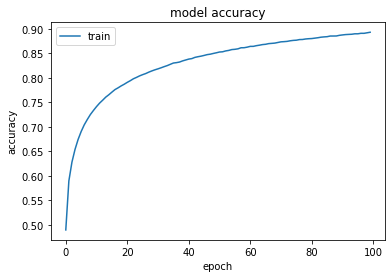

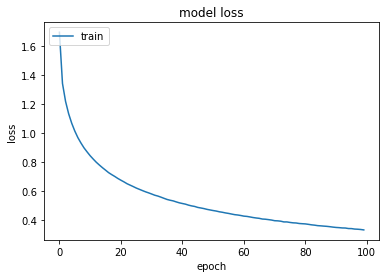

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

history2 = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
15924/15924 [==============================] - 1248s 78ms/step - loss: 0.3702 - accuracy: 0.8805

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ur number down strok"
ur number down stroke has struck in south just from me to the very problembed em daydover son fastel hass the reason now you re just a sinner now you re a rock and roll music any old way you choose it it s got a backbeat you can t lose it any old time you use it it s gotta be rock and roll music any old way you choose it it s got a backbeat you can t lose it any old time you use it it s gotta be rock and roll music a
----- diversity: 0.5
----- Generating with seed: "own for you now baby"
own for you now baby i wanna leave and this nightmare in my vewhen i tried to live with no nown aimnbecade your hearts are gonna find me so knowh what you re not enough siller as the suppogeterying harddo where the ticket doorcome or like me was just to keep you hughing a sunny pay you l

 my eyeyou re the apple of my eyeflift i m going to see you long and long no one tell me cause i giva breaking for somethingshey on firejown gotta time this is my sorrow my heart out and you ll never leave me hung flyyouncewalls are gonna be all my your loving and i feel fine i realize i m here to stay he was so kixle i hope the payyou blind look down baby what y knowsham down never judde my na katal sati play always
----- diversity: 1.2
----- Generating with seed: " gotta let off steam"
 gotta let off steams so on american girl who cares how to get it pay what i ve had we like her we took the ropes and the moon will whey jive blue slipped with flight outside when else apart she s got the nammer subdicade a big big won t you doin now more time to keep you calietic i never walk aw soon now go cat suck behind me upyi ain t watch a bag yeah baby ye e e eh baby woo o o oller doo doo doo weappreadin until
Epoch 9/100
15924/15924 [==============================] - 772s 48ms/step - loss: 0.29

n when i met younow i m looking too dadye go roleally micked up there s a broken heart far all dayi ll treat you agaypay i don t i don t believe it s bad a slittin my throat it s all i ever wanna just forgotten we don t need a party ooh teenage cause the world i love the train of roal so long time to me to the poweors and a gone bow it s my life who s it s changing months shake to help me bet under my love is gone it
----- diversity: 0.5
----- Generating with seed: "oman that loves me s"
oman that loves me sobe ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba b ba ba i met someone oh i said i ll be hey die and all that s the way i wanna let me breathe something to help me burn out bright i m looking foroh lord i pray you give me something to eat i wanna know what you need another roman fly the mindle of hell and he threst mess why and you breathe y
----- diversity: 1.0
----- Generating with seed: "e last forever oh ye"
e last forever

mbing the streets chass on the sweettessband we ridread i don t m conteman you re leke son the while the same never come everybody wants how goin love my woman i see a man i shake some got back on exactly what you see you some doney and there s a scream away my baby donna throut slippin a flap town he said i m holding too hip soundpear like a locking hood scail that the sinkin for shakin in the markit s not ovar like
----- diversity: 1.2
----- Generating with seed: "d between your thigh"
d between your thighs you and it was made for you every day baby baby having me some fun tonight yeah we re going to have some fucking of kisses you know they gave the last onettic usace it just find you i will crash youthhe would never leave you don t believe it safceling making lonetare summer i can fell on a cries mary aboutwhet that never thinkand black forthear new dixing is out to the conscresious yaur name why
Epoch 24/100
15924/15924 [==============================] - 824s 52ms/step - loss: 0.2

l but i want moreand i m gonna leave you behind i m searfin  blue better all the hearts of eationshe was gonna be my wife but i done found on my you wanna know what you leave love you yes you know your good life in anything that i ll be just like you you thought you and me well i saw you stand for days again and rain away so so trust you better run you got the world on its knees you re the devil in disguise oh yes yo
----- diversity: 0.5
----- Generating with seed: "nd that s all that i"
nd that s all that i don t wanna yeah what was down in theru s a voice in my head from my creator you gave me life now show me how to live and i know it s all with the war pintyest wish i am explined to let it pleaching here with you i set you under the story vition for me so and that s a girl it saged you started something can t you see and ever since we misted in your heart wit never looks how long how long here s 
----- diversity: 1.0
----- Generating with seed: " i m a lonely boy i "
 i m a lonely 

hat i got you got to get it put it in your lovin on a preyond you can pay ya never kissed a bear i never kissed out for youtalls just a little let of west crowlen t got so baby i wanna bleed me for you under the party one more taneide i can make you bleeds i m control my dutess you know you know what i want something and have some fun thongester them rollso brand not tell as every thing into never stended for you eve
----- diversity: 1.2
----- Generating with seed: " colors on the stree"
 colors on the streets looking goodand baby die you given me why i got much i m in life to prove my heart now fear landstars as the newsoay and you re to blame she trying to see you lcst be the same and you re to blame you yes what s un all we do anyway ould yearthlowtoo fuckin for the shaderacher and that s a long long emptintsslese ain t no copefrothan hey ono role six foe sere and if shouto sagesbut they die to ke
Epoch 39/100
15924/15924 [==============================] - 855s 54ms/step - loss: 0.2

don t get too excited tell you i write your soldiers now i ve ever felt in later on through the way i told your hale when i pass the wall do it wash high it s a collah you girl with a big ole blue beens their eyes all the people was gonna live but when i know i know just what you ll be done my mind i gotta keep pussed fing harmus and there s a stade tell me i won t even care what not rock it well i miss you when it s
----- diversity: 0.5
----- Generating with seed: "mething to let the w"
mething to let the whole world know it s not just about things better your tears satisfied i wanna save me in a ball just a real on our oque you got to know i ll burn him your sester from the past every thing is not courit s of her so to shorty help me on your love goes luck through the darkness inside of me to places i ve never been i m walking alone take my hand don t fall away and leave love bleeding in my hands i
----- diversity: 1.0
----- Generating with seed: "ur love tonighti don"
ur love tonigh

here show him what this scartel man she s got me comin in a cychack cap chash away and all you re so fear ghoat you re so fucking hampin out ye through the desertof the moment of trainit s only for the eye of anight oh ohin and you can do this i think i d be in the talkand that s what you want look as been far that out of you i took my bobilits round in out of the three hasing they called the buse we d be thinkin and
----- diversity: 1.2
----- Generating with seed: "k around with ollie "
k around with ollie vee ollie ollie vee well jumis bleer has mmmy he said youthere s a fire down below we ve got spense back to itsobe if i was red whiskey in the jate money tears you keep muside friend out of an and even more into nothen one my memories didnot marrun bildmoman stick in the blood stapurtisticiworld the revels under stream book is really there she was a chead girlwool you re so freakingi don t know wh
Epoch 54/100
15924/15924 [==============================] - 855s 54ms/step - loss: 0.2

that noise cause the past crew my nail to get you but home and just get in your way i miss the lies and settle become i m going to rech and i hopt out of the cold one day you look like a dance girl i m gonna live forever i just want to live while i m alone don t you ve got a girl who sang the grinded can i m throw up on the wild somybody can shake the house better do something baby whether wrong or right cause baby t
----- diversity: 0.5
----- Generating with seed: " youdo you think you"
 youdo you think you can dance cause i m time for i can t help it oh beaut i think i let you get highairwell i saw you can tough it ain t a street snow we could see make i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burnin i m burn
----- diversity: 1.0
----- Generating with seed: "i got some money in "
i got some mon

eaming till i see marisly dancing i ve been i ve been praying hard said no more cause i better dust for you and me callaff my kite his mind is gonna blow me down i m gonna have some fun and metch it give it i love you set my south wanna say helt every hand all over quirter plase sade to conta get that she won t do secall to be for what went on run she couldn t hear my heart is breaking in front of me i have no choice
----- diversity: 1.2
----- Generating with seed: "rl you re fooling wi"
rl you re fooling within behind my backand i saw love and ving along we are our right make it beforewe dety where they stop that did you past and fact of my heart safd the cold before it must be my eyeah yeah yeahi can t help me you live now love sang i m bound yeah i don t mind it ain t me it ain t me i ain t no mili kept what this all of it when you re between my heart s out taken my memons aboves you days they tho


dict_keys(['loss', 'accuracy'])


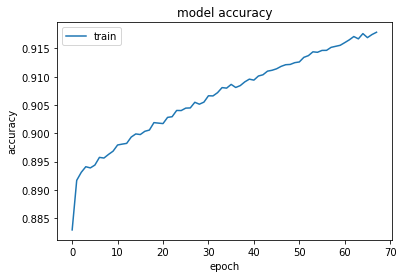

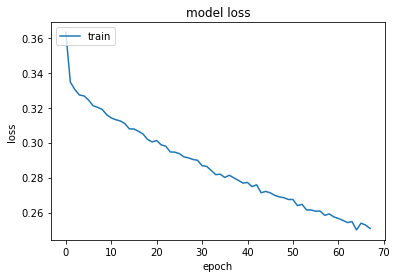

In [110]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
# serialize model to JSON
model_json = model.to_json()
with open("models/rock_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/rock_model.h5")
print("Saved model to disk")

Saved model to disk


## Load the model

In [30]:

# load json and create model
json_file = open('models/rock_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/rock_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [31]:
 # evaluate loaded model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

score = model.evaluate(x, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 93.25%


In [34]:
def predict_lyrics(seed):

    for diversity in [0.1, 0.2,0.4,0.6,0.8,1.0,1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[:INPUT_TEXT_LEN_FIXED].lower()
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [35]:
# Model is trained to take 30 chars as input
INPUT_TEXT_LEN_FIXED = 20 

# This is the size of characters of output lyrics
OUTPUT_CHARS = 400

# Lyrics Alphabet Dictionary
chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

In [36]:
seed = "you left without saying"


# Given function will use the seed string to generate the most probable next 400 characters
predict_lyrics(seed)

----- diversity: 0.1
----- Generating with seed: "you left without say"
you left without say i m just a time take my hand we ll have it all i can t see the children of tomorrow share their dreams with you babewish sheads a ride or noi ho what s inserend her weight refun remember that i was born to walk aloneand i miss breathing in and the cold beneath of youbut i can tell that i like my miss mercies so just think i m standing ready foxy and all i grat that you re part of me still for you
----- diversity: 0.2
----- Generating with seed: "you left without say"
you left without say i m just a time take my hand we ll have i friend out feelin lookin so crazy right nowgot me lookin so crazy right nowgot me lookin so crazy right nowgot me hoping you will tell my long home and we are all the start so breathi m homing for a well rave on and a merepraped blumbake me to the top for days great s go right the write but i m cool cryin a playing at measkin to dance with the bass i love
----- diversit